In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim

In [30]:
train=pd.read_csv('train_2_features.csv')
valid=pd.read_csv('valid_2_features.csv')
test=pd.read_csv('test_2_features.csv')

In [31]:
feature1 = train.columns[0]
feature2 = train.columns[1]
target_col = train.columns[2]

In [32]:
features = train.columns[0:2].tolist()
features

['C6H6(GT)', 'PT08.S2(NMHC)']

In [33]:
X_train = torch.tensor(train[features].values.reshape(-1,2), dtype=torch.float32)
y_train = torch.tensor(train[target_col], dtype=torch.float32).view(-1,1)


X_valid = torch.tensor(valid[features].values.reshape(-1,2), dtype=torch.float32)
y_valid = torch.tensor(valid[target_col], dtype=torch.float32).view(-1,1)


X_test = torch.tensor(test[features].values.reshape(-1,2), dtype=torch.float32)
y_test = torch.tensor(test[target_col], dtype=torch.float32).view(-1,1)

In [34]:
class NeuralNet (nn.Module):
    def __init__ (self, input_size, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(input_size, hidden_dim) ,
        nn.Sigmoid() ,
        nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.network(x)

In [42]:
hidden_layers = [8, 16, 32, 64]

best_modal = None
best_rmse=float('inf')
best_hidden = None

loss_history = {}
epochs = 100

y_test_pred_seq ={}

y_train_rmse ={}
y_test_rmse ={}
y_valid_rmse ={}

In [43]:
for hidden in hidden_layers:
    model = NeuralNet(input_size = 2,hidden_dim = hidden)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    losses=[]

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    loss_history[hidden] = losses

    y_test_pred = model(X_test).detach().numpy()
    y_valid_pred = model(X_valid).detach().numpy()
    y_train_pred = model(X_train).detach().numpy()

    y_test_pred_seq[hidden] = y_test_pred

    rmse_val = sqrt(mean_squared_error(y_valid_pred, y_valid))
    y_train_rmse[hidden] = sqrt(mean_squared_error(y_train, y_train_pred))
    y_valid_rmse[hidden] = sqrt(mean_squared_error(y_valid, y_valid_pred))
    y_test_rmse[hidden] = sqrt(mean_squared_error(y_test, y_test_pred))


    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_model = model
        best_hidden = hidden

In [58]:
X_train

tensor([[  14.6000, 1136.0000],
        [  11.8000, 1044.0000],
        [  15.4000, 1160.0000],
        ...,
        [   2.7000,  636.0000],
        [   3.6000,  687.0000],
        [  12.0000, 1048.0000]])

In [44]:
best_rmse

1.4299096940609766

In [45]:
best_model

NeuralNet(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [46]:
print(f"Lowest validation rmse is: {best_rmse} with hidden layers: {best_hidden}")

Lowest validation rmse is: 1.4299096940609766 with hidden layers: 8


In [47]:
y_valid_rmse

{8: 1.4299096940609766,
 16: 1.4299158633095896,
 32: 1.4300539141275064,
 64: 1.4299160300456693}

In [48]:
print(f"RMSE on test dataset for best model: {y_test_rmse[best_hidden]}")

RMSE on test dataset for best model: 1.4751256178043322


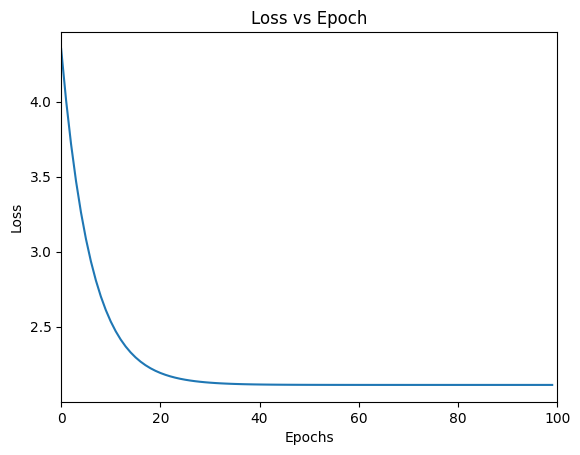

In [50]:
plt.plot(range(epochs), loss_history[best_hidden])
plt.xlim(0, 100)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

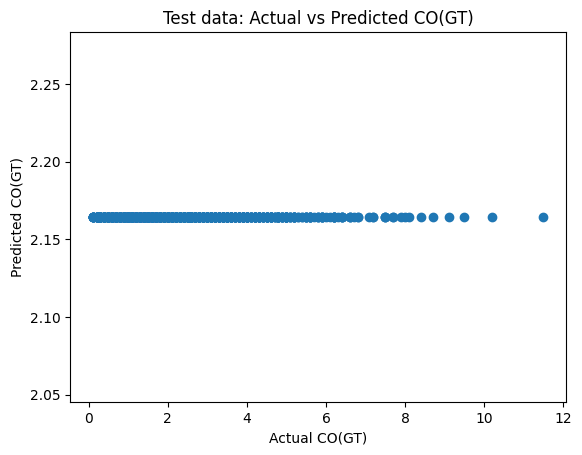

In [51]:
plt.scatter(y_test, y_test_pred_seq[best_hidden])
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Test data: Actual vs Predicted CO(GT)")

plt.show()

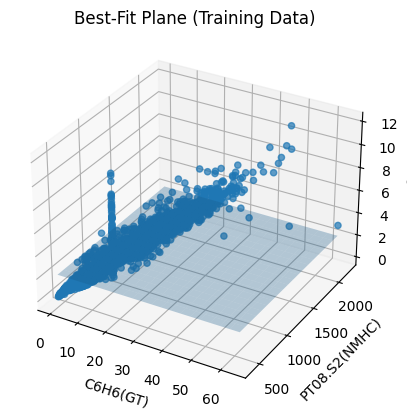

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train[feature1], train[feature2], y_train, alpha=0.7)

# Create a mesh for plotting the plane
x_surf = np.linspace(train[feature1].min(), train[feature1].max(), 20)
y_surf = np.linspace(train[feature2].min(), train[feature2].max(), 20)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

z_surf = best_model(torch.tensor(np.column_stack((x_surf.ravel(), y_surf.ravel())), dtype=torch.float32))
z_surf = z_surf.reshape(x_surf.shape)

# x_surf = x_surf.detach().numpy()
# y_surf = y_surf.detach().numpy()
z_surf = z_surf.detach().numpy()

ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.3)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_zlabel(target_col)
ax.set_title("Best-Fit Plane (Training Data)")
plt.show()